In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re

# Machine Learning libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

# For model persistence
import joblib

# For loading dataset from Hugging Face
from datasets import load_dataset

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [2]:
print("Loading Medical Cases Classification Dataset from Hugging Face...")
print("This may take 1-2 minutes on first run (downloading ~50MB)...\n")

# Load dataset (pre-split into train/validation/test)
dataset = load_dataset("hpe-ai/medical-cases-classification-tutorial")

# Convert to pandas DataFrames for easier manipulation
train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

print("✅ Dataset loaded successfully!")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(val_df) + len(test_df)}")

Loading Medical Cases Classification Dataset from Hugging Face...
This may take 1-2 minutes on first run (downloading ~50MB)...



Repo card metadata block was not found. Setting CardData to empty.


✅ Dataset loaded successfully!
Training samples: 1724
Validation samples: 370
Test samples: 370
Total samples: 2464


## Load the Medical Dataset
<!-- Purpose: Download and load the medical transcription dataset from Hugging Face
The dataset contains 2,460 medical case transcriptions across 13 specialties -->

In [3]:
print("\n" + "="*70)
print("DATASET STRUCTURE OVERVIEW")
print("="*70)

print(f"\nDataset shape: {train_df.shape}")
print(f"Number of features: {train_df.shape[1]}")
print(f"Feature names: {list(train_df.columns)}")

print("\n" + "-"*70)
print("First 3 samples:")
print("-"*70)
display(train_df.head(3))

print("\n" + "-"*70)
print("Dataset Information:")
print("-"*70)
print(train_df.info())

print("\n" + "-"*70)
print("Missing Values Check:")
print("-"*70)
print(train_df.isnull().sum())

print("\n" + "-"*70)
print("Basic Statistics:")
print("-"*70)
print(train_df.describe(include='all'))


DATASET STRUCTURE OVERVIEW

Dataset shape: (1724, 5)
Number of features: 5
Feature names: ['description', 'transcription', 'sample_name', 'medical_specialty', 'keywords']

----------------------------------------------------------------------
First 3 samples:
----------------------------------------------------------------------


,description,transcription,sample_name,medical_specialty,keywords
0,Pacemaker ICD interrogation. Severe nonischem...,"PROCEDURE NOTE: , Pacemaker ICD interrogation....",Pacemaker Interrogation,Cardiovascular / Pulmonary,"cardiovascular / pulmonary, cardiomyopathy, ve..."
1,"Erythema of the right knee and leg, possible s...","PREOPERATIVE DIAGNOSES: , Erythema of the righ...",Aspiration - Knee Joint,Orthopedic,"orthopedic, knee and leg, anterolateral portal..."
2,Left cardiac catheterization with selective ri...,"PREOPERATIVE DIAGNOSIS: , Post infarct angina....",Cardiac Cath & Selective Coronary Angiography,Cardiovascular / Pulmonary,"cardiovascular / pulmonary, selective, angiogr..."



----------------------------------------------------------------------
Dataset Information:
----------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1724 entries, 0 to 1723
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        1724 non-null   object
 1   transcription      1724 non-null   object
 2   sample_name        1724 non-null   object
 3   medical_specialty  1724 non-null   object
 4   keywords           1109 non-null   object
dtypes: object(5)
memory usage: 67.5+ KB
None

----------------------------------------------------------------------
Missing Values Check:
----------------------------------------------------------------------
description            0
transcription          0
sample_name            0
medical_specialty      0
keywords             615
dtype: int64

---------------------------------------------------

## Initial Data Exploration
<!-- Purpose: Understand the structure and content of the dataset -->

In [4]:
print("\n" + "="*70)
print("TEXT LENGTH ANALYSIS")
print("="*70)

# Calculate character lengths for both text fields
train_df['transcription_length'] = train_df['transcription'].str.len()
train_df['description_length'] = train_df['description'].str.len()

# Calculate word counts for both text fields
train_df['transcription_words'] = train_df['transcription'].str.split().str.len()
train_df['description_words'] = train_df['description'].str.split().str.len()

print("\nCharacter Length Statistics:")
print("-"*70)
print(f"Transcription:")
print(f"  Mean: {train_df['transcription_length'].mean():.1f} characters")
print(f"  Median: {train_df['transcription_length'].median():.1f} characters")
print(f"  Min: {train_df['transcription_length'].min():.0f} characters")
print(f"  Max: {train_df['transcription_length'].max():.0f} characters")

print(f"\nDescription:")
print(f"  Mean: {train_df['description_length'].mean():.1f} characters")
print(f"  Median: {train_df['description_length'].median():.1f} characters")
print(f"  Min: {train_df['description_length'].min():.0f} characters")
print(f"  Max: {train_df['description_length'].max():.0f} characters")

print("\nWord Count Statistics:")
print("-"*70)
print(f"Transcription:")
print(f"  Mean: {train_df['transcription_words'].mean():.1f} words")
print(f"  Median: {train_df['transcription_words'].median():.1f} words")

print(f"\nDescription:")
print(f"  Mean: {train_df['description_words'].mean():.1f} words")
print(f"  Median: {train_df['description_words'].median():.1f} words")


TEXT LENGTH ANALYSIS

Character Length Statistics:
----------------------------------------------------------------------
Transcription:
  Mean: 3326.2 characters
  Median: 2850.5 characters
  Min: 13 characters
  Max: 15216 characters

Description:
  Mean: 140.4 characters
  Median: 123.5 characters
  Min: 14 characters
  Max: 491 characters

Word Count Statistics:
----------------------------------------------------------------------
Transcription:
  Mean: 504.0 words
  Median: 427.0 words

Description:
  Mean: 19.7 words
  Median: 16.0 words


## Text Length Analysis - Calculate Statistics
<!-- Purpose: Analyze the length of transcriptions and descriptions
This helps us understand document sizes and choose appropriate features -->

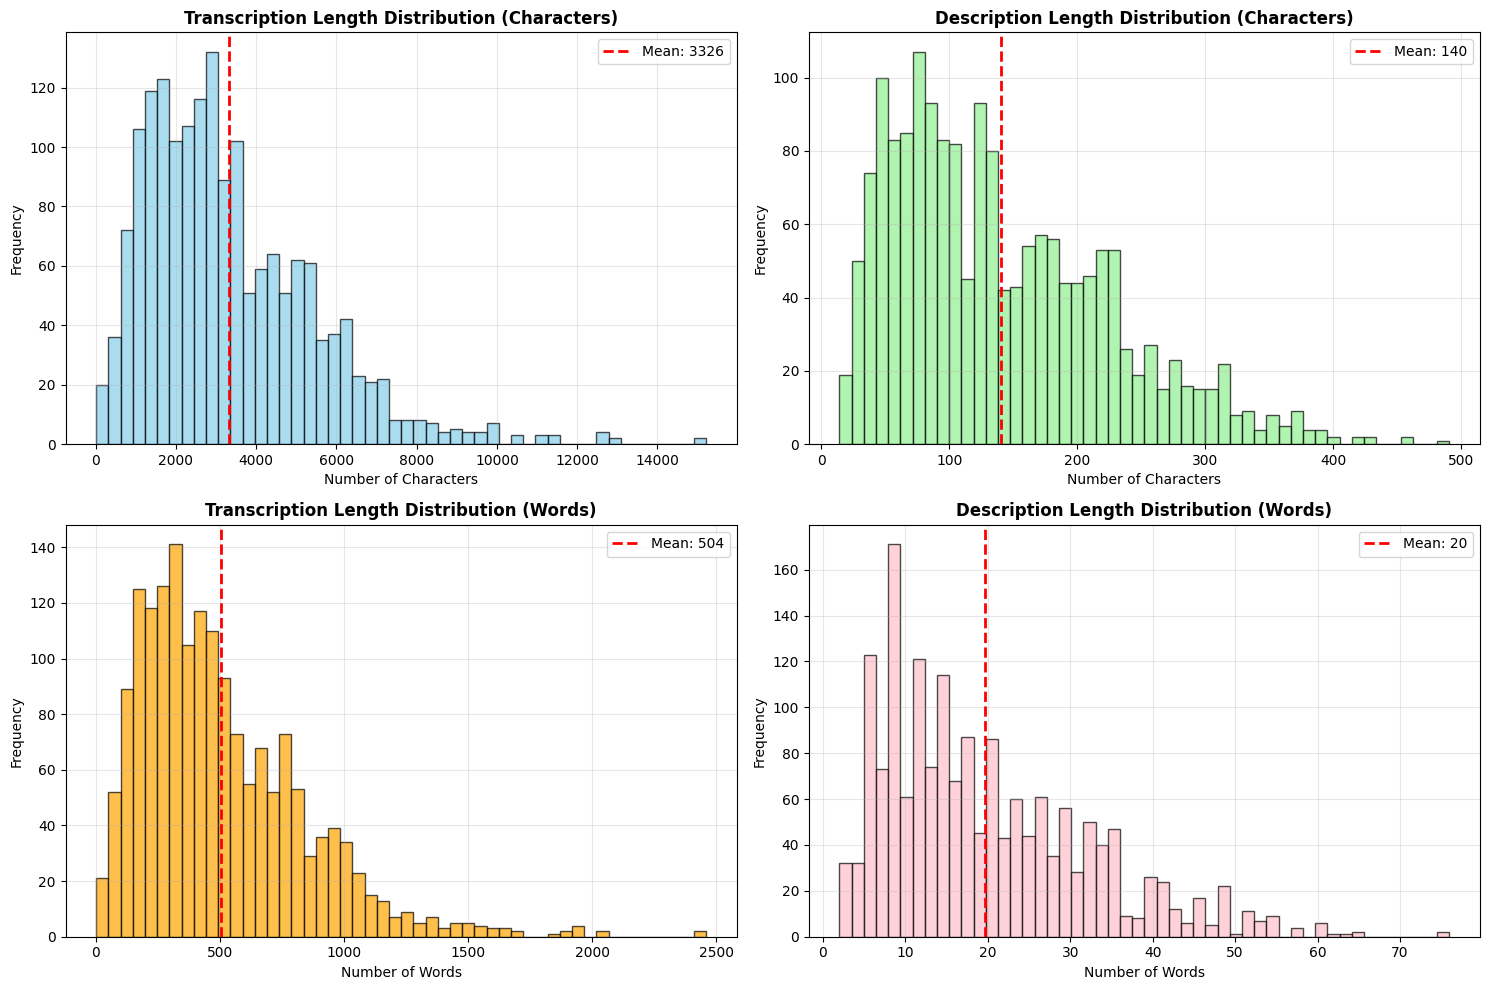

📊 Observation: Transcriptions are significantly longer than descriptions
💡 Recommendation: Use 'transcription' field as primary feature for classification


In [5]:
# Create a 2x2 grid of histograms
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Transcription character length distribution
axes[0,0].hist(train_df['transcription_length'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Transcription Length Distribution (Characters)', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Number of Characters')
axes[0,0].set_ylabel('Frequency')
axes[0,0].axvline(train_df['transcription_length'].mean(), color='red', linestyle='--', 
                  linewidth=2, label=f'Mean: {train_df["transcription_length"].mean():.0f}')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# Plot 2: Description character length distribution
axes[0,1].hist(train_df['description_length'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Description Length Distribution (Characters)', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Number of Characters')
axes[0,1].set_ylabel('Frequency')
axes[0,1].axvline(train_df['description_length'].mean(), color='red', linestyle='--', 
                  linewidth=2, label=f'Mean: {train_df["description_length"].mean():.0f}')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

# Plot 3: Transcription word count distribution
axes[1,0].hist(train_df['transcription_words'], bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1,0].set_title('Transcription Length Distribution (Words)', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Number of Words')
axes[1,0].set_ylabel('Frequency')
axes[1,0].axvline(train_df['transcription_words'].mean(), color='red', linestyle='--', 
                  linewidth=2, label=f'Mean: {train_df["transcription_words"].mean():.0f}')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

# Plot 4: Description word count distribution
axes[1,1].hist(train_df['description_words'], bins=50, alpha=0.7, color='pink', edgecolor='black')
axes[1,1].set_title('Description Length Distribution (Words)', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('Number of Words')
axes[1,1].set_ylabel('Frequency')
axes[1,1].axvline(train_df['description_words'].mean(), color='red', linestyle='--', 
                  linewidth=2, label=f'Mean: {train_df["description_words"].mean():.0f}')
axes[1,1].legend()
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Observation: Transcriptions are significantly longer than descriptions")
print("💡 Recommendation: Use 'transcription' field as primary feature for classification")

## Text Length Visualization
<!-- Purpose: Create visual representations of document length distributions
Helps identify patterns and outliers in document sizes -->

In [6]:
print("\n" + "="*70)
print("TARGET VARIABLE ANALYSIS - MEDICAL SPECIALTIES")
print("="*70)

# Count samples per specialty
specialty_counts = train_df['medical_specialty'].value_counts()

print("\nMedical Specialties Distribution:")
print("-"*70)
for specialty, count in specialty_counts.items():
    percentage = (count / len(train_df)) * 100
    print(f"{specialty:40s}: {count:4d} documents ({percentage:5.2f}%)")

print("\n" + "-"*70)
print(f"Total unique specialties: {train_df['medical_specialty'].nunique()}")

# Calculate class imbalance ratio
imbalance_ratio = specialty_counts.max() / specialty_counts.min()
print(f"\n⚠️  Class Imbalance Detected!")
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")
print(f"Most common: {specialty_counts.index[0]} ({specialty_counts.iloc[0]} documents)")
print(f"Least common: {specialty_counts.index[-1]} ({specialty_counts.iloc[-1]} documents)")

print("\n💡 Business Impact: Class imbalance may cause model to favor majority classes")
print("   This could lead to misclassification of rare but important specialties")


TARGET VARIABLE ANALYSIS - MEDICAL SPECIALTIES

Medical Specialties Distribution:
----------------------------------------------------------------------
Cardiovascular / Pulmonary              :  526 documents (30.51%)
Orthopedic                              :  289 documents (16.76%)
Neurology                               :  187 documents (10.85%)
Gastroenterology                        :  152 documents ( 8.82%)
Obstetrics / Gynecology                 :  126 documents ( 7.31%)
Hematology - Oncology                   :   86 documents ( 4.99%)
Neurosurgery                            :   76 documents ( 4.41%)
ENT - Otolaryngology                    :   53 documents ( 3.07%)
Pediatrics - Neonatal                   :   51 documents ( 2.96%)
Psychiatry / Psychology                 :   49 documents ( 2.84%)
Nephrology                              :   45 documents ( 2.61%)
Ophthalmology                           :   45 documents ( 2.61%)
Radiology                               :   39 documen

## Target Variable Analysis - Class Distribution
<!-- Purpose: Analyze the distribution of medical specialties (target variable)
Critical for identifying class imbalance issues -->

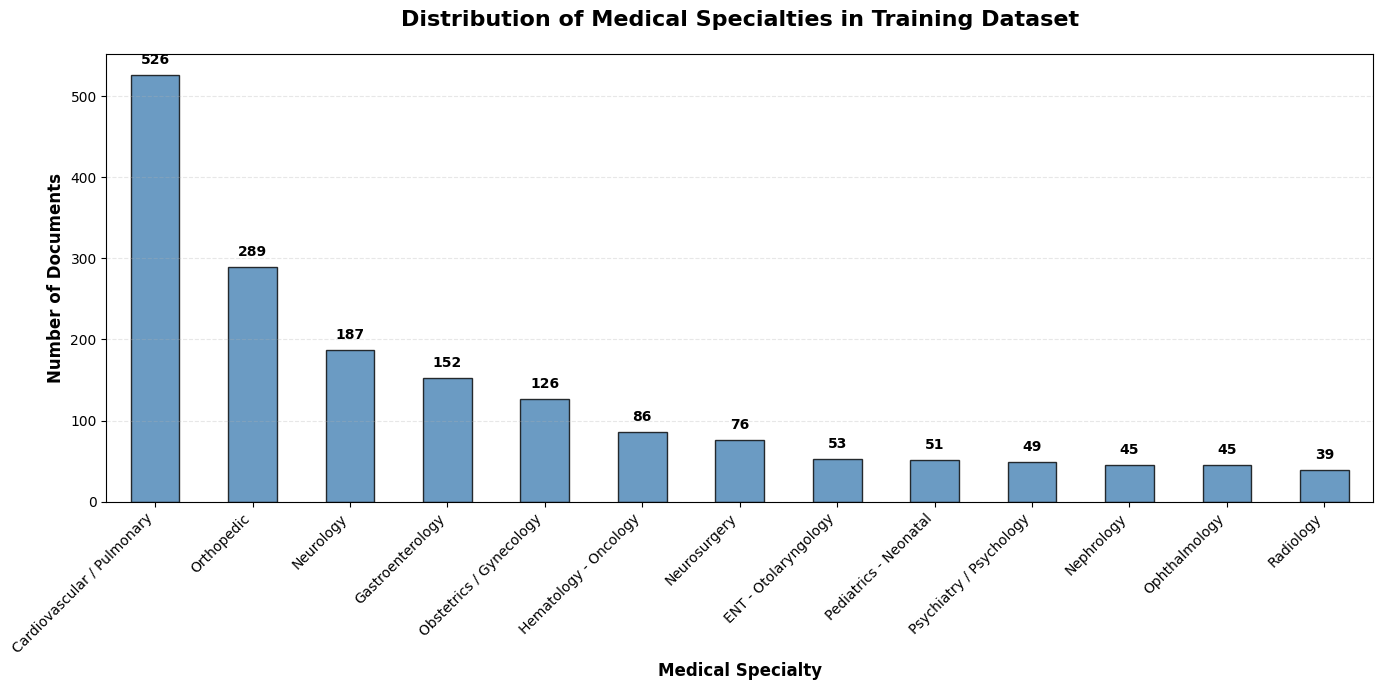

In [7]:
plt.figure(figsize=(14, 7))
specialty_counts.plot(kind='bar', color='steelblue', alpha=0.8, edgecolor='black')
plt.title('Distribution of Medical Specialties in Training Dataset', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Medical Specialty', fontsize=12, fontweight='bold')
plt.ylabel('Number of Documents', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on top of bars
for i, v in enumerate(specialty_counts.values):
    plt.text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Visualize Class Distribution - Bar Chart
<!-- Purpose: Create a clear visual representation of specialty distribution
Essential for stakeholder communication -->

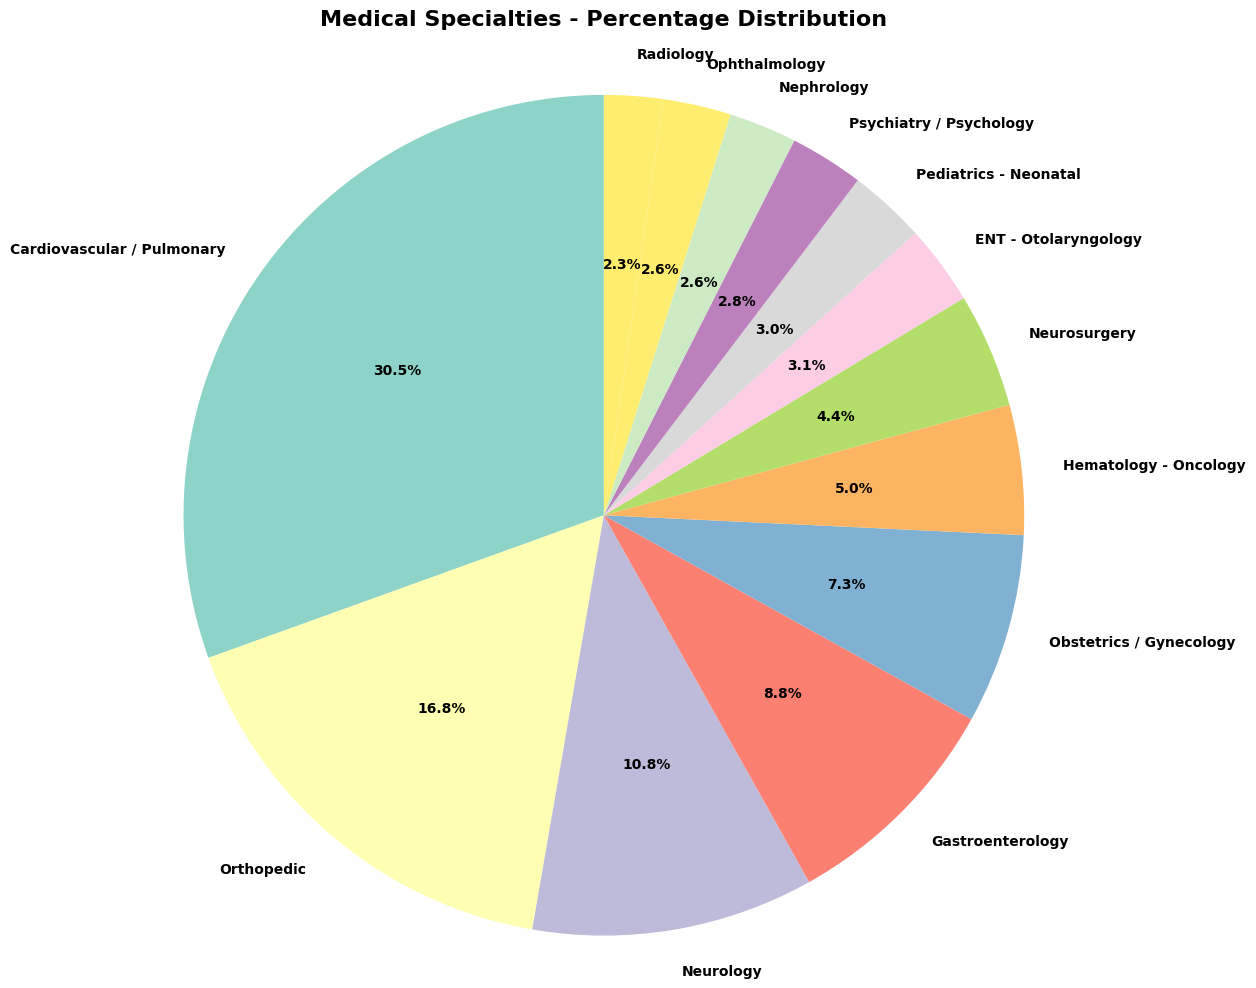

In [8]:
plt.figure(figsize=(12, 10))
colors = plt.cm.Set3(range(len(specialty_counts)))
plt.pie(specialty_counts.values, 
        labels=specialty_counts.index, 
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        textprops={'fontsize': 10, 'fontweight': 'bold'})
plt.title('Medical Specialties - Percentage Distribution', 
          fontsize=16, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

## Visualize Class Distribution - Pie Chart
<!-- Purpose: Show percentage distribution of specialties
Alternative visualization for understanding class proportions -->

In [9]:
print("\n" + "="*70)
print("TEXT CONTENT ANALYSIS - WORD FREQUENCY")
print("="*70)

# Function to clean text for word frequency analysis
def clean_text_for_analysis(text):
    """
    Clean text by:
    1. Converting to lowercase
    2. Removing special characters and numbers
    3. Removing extra whitespace
    """
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Combine all transcriptions into one text corpus
all_text = ' '.join(train_df['transcription'].astype(str))
cleaned_text = clean_text_for_analysis(all_text)

# Count word frequencies
word_freq = Counter(cleaned_text.split())

# Define common English stop words to exclude
stop_words = {'the', 'and', 'to', 'of', 'a', 'in', 'is', 'it', 'you', 'that', 
              'he', 'was', 'for', 'on', 'are', 'as', 'with', 'his', 'they', 
              'i', 'at', 'be', 'this', 'have', 'from', 'or', 'one', 'had', 
              'by', 'but', 'not', 'what', 'all', 'were', 'we', 'when', 'your', 
              'can', 'said', 'there', 'use', 'an', 'each', 'which', 'she', 
              'do', 'how', 'their', 'if', 'will', 'up', 'other', 'about', 
              'out', 'many', 'then', 'them', 'these', 'so', 'some', 'her', 
              'would', 'make', 'like', 'into', 'him', 'time', 'has', 'look', 
              'two', 'more', 'go', 'see', 'no', 'way', 'could', 'my', 'than', 
              'been', 'who', 'its', 'now', 'find', 'any', 'new', 'work', 'part', 
              'take', 'get', 'place', 'made', 'where', 'after', 'back', 'only', 
              'me', 'our', 'over', 'such', 'because', 'even', 'most', 'also', 
              'did', 'may', 'before', 'must', 'through', 'same', 'should', 'under'}

# Filter out stop words and short words
filtered_freq = {word: count for word, count in word_freq.items() 
                if word not in stop_words and len(word) > 2}

# Get top 30 most common medical terms
top_words = Counter(filtered_freq).most_common(30)

print("\nTop 30 Most Common Medical Terms:")
print("-"*70)
for i, (word, count) in enumerate(top_words, 1):
    print(f"{i:2d}. {word:20s}: {count:6d} occurrences")


TEXT CONTENT ANALYSIS - WORD FREQUENCY

Top 30 Most Common Medical Terms:
----------------------------------------------------------------------
 1. patient             :   7444 occurrences
 2. right               :   4671 occurrences
 3. left                :   4404 occurrences
 4. history             :   3201 occurrences
 5. normal              :   2517 occurrences
 6. placed              :   2481 occurrences
 7. well                :   2061 occurrences
 8. pain                :   1846 occurrences
 9. artery              :   1761 occurrences
10. procedure           :   1746 occurrences
11. performed           :   1505 occurrences
12. using               :   1467 occurrences
13. noted               :   1404 occurrences
14. anterior            :   1341 occurrences
15. removed             :   1337 occurrences
16. used                :   1329 occurrences
17. blood               :   1302 occurrences
18. without             :   1283 occurrences
19. incision            :   1178 occurrences

## Text Content Analysis - Word Frequency
<!-- Purpose: Identify the most common medical terms across all documents
Helps understand vocabulary and domain-specific language -->


Generating word cloud for all medical transcriptions...


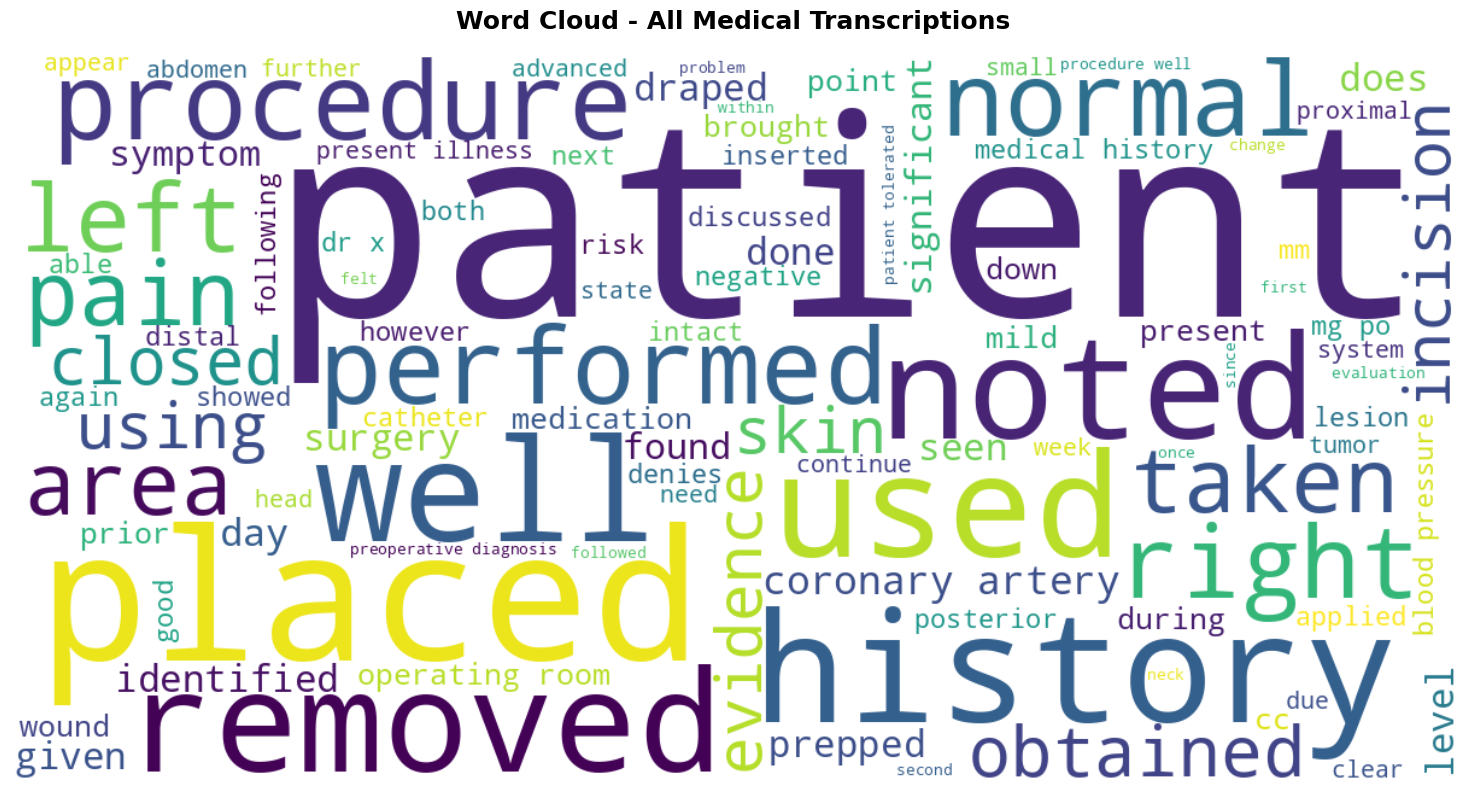

✅ Word cloud generated successfully
💡 Larger words indicate higher frequency in medical documents


In [10]:
print("\nGenerating word cloud for all medical transcriptions...")

# Generate word cloud
wordcloud = WordCloud(
    width=1200, 
    height=600,
    background_color='white',
    stopwords=stop_words,
    max_words=100,
    colormap='viridis',
    relative_scaling=0.5,
    min_font_size=10
).generate(cleaned_text)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - All Medical Transcriptions', 
          fontsize=18, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("✅ Word cloud generated successfully")
print("💡 Larger words indicate higher frequency in medical documents")

## Word Cloud - All Documents
<!-- Purpose: Visual representation of most frequent medical terms
Larger words appear more frequently in the corpus -->


SPECIALTY-SPECIFIC WORD ANALYSIS

Analyzing word patterns for top 3 specialties:
1. Cardiovascular / Pulmonary: 526 documents
2. Orthopedic: 289 documents
3. Neurology: 187 documents


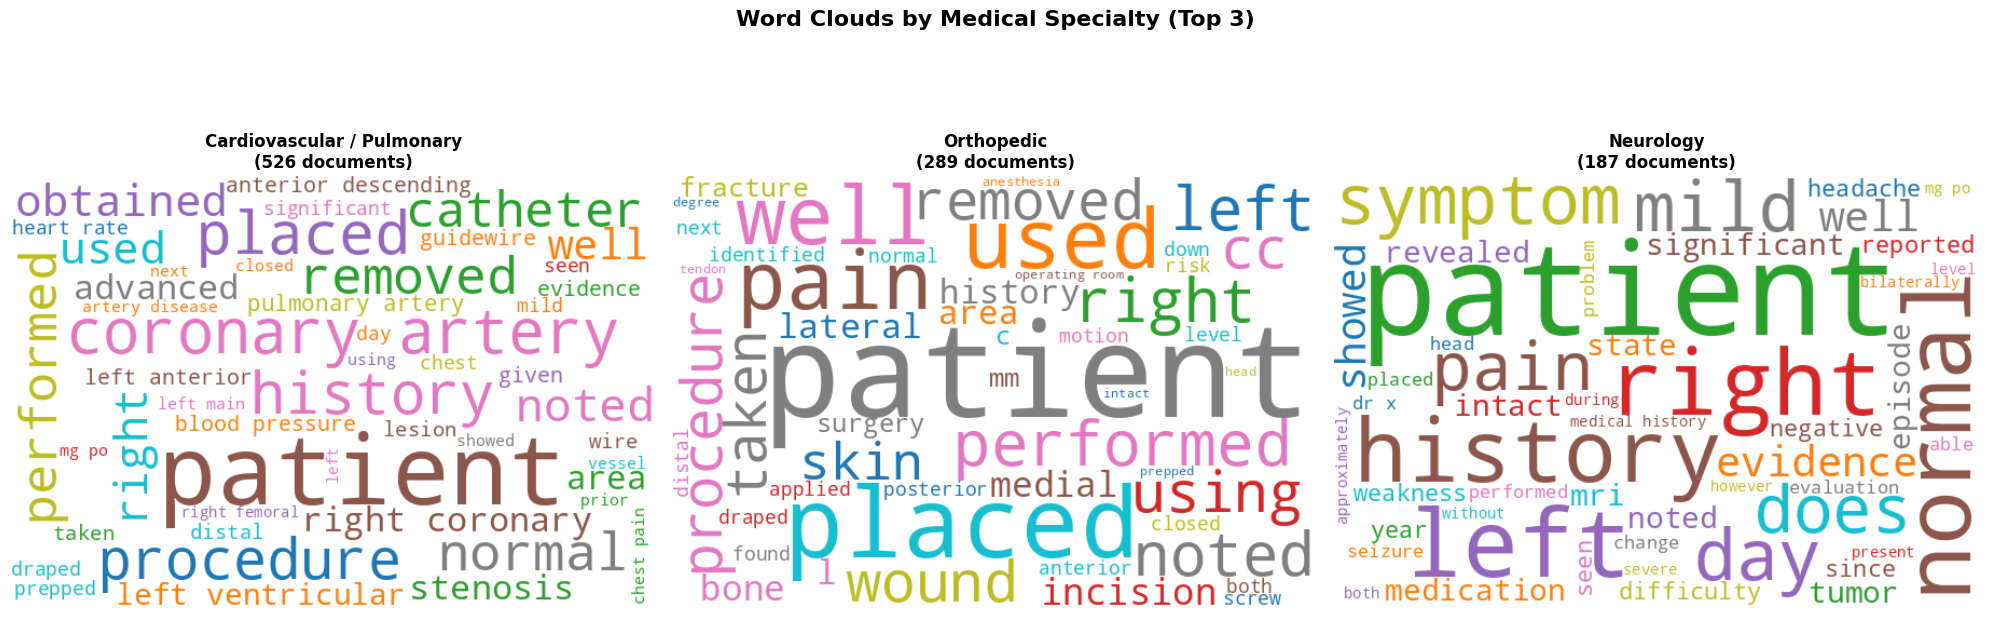


💡 Key Insight: Each specialty has distinct vocabulary patterns
   This suggests text-based classification is feasible


In [11]:
print("\n" + "="*70)
print("SPECIALTY-SPECIFIC WORD ANALYSIS")
print("="*70)

# Select top 3 most common specialties for detailed analysis
top_specialties = specialty_counts.head(3).index

print(f"\nAnalyzing word patterns for top 3 specialties:")
for i, spec in enumerate(top_specialties, 1):
    doc_count = specialty_counts[spec]
    print(f"{i}. {spec}: {doc_count} documents")

# Create word clouds for top 3 specialties
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

for idx, specialty in enumerate(top_specialties):
    # Get all documents for this specialty
    specialty_docs = train_df[train_df['medical_specialty'] == specialty]['transcription']
    specialty_text = ' '.join(specialty_docs.astype(str))
    cleaned_specialty_text = clean_text_for_analysis(specialty_text)
    
    # Generate word cloud for this specialty
    wordcloud = WordCloud(
        width=600, 
        height=400,
        background_color='white',
        stopwords=stop_words,
        max_words=50,
        colormap='tab10',
        relative_scaling=0.5
    ).generate(cleaned_specialty_text)
    
    # Display word cloud
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].axis('off')
    axes[idx].set_title(f'{specialty}\n({len(specialty_docs)} documents)', 
                       fontsize=12, fontweight='bold')

plt.suptitle('Word Clouds by Medical Specialty (Top 3)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 Key Insight: Each specialty has distinct vocabulary patterns")
print("   This suggests text-based classification is feasible")

## Specialty-Specific Word Clouds
<!-- Purpose: Identify unique vocabulary patterns for each medical specialty
Helps understand what distinguishes different specialties -->


FEATURE SELECTION ANALYSIS

Comparing 'transcription' vs 'description' fields:
----------------------------------------------------------------------

Transcription field:
  Average length: 3326 characters
  Average words: 504 words
  Information density: High (detailed medical notes)

Description field:
  Average length: 140 characters
  Average words: 20 words
  Information density: Low (brief summary)

Correlation between lengths: 0.300


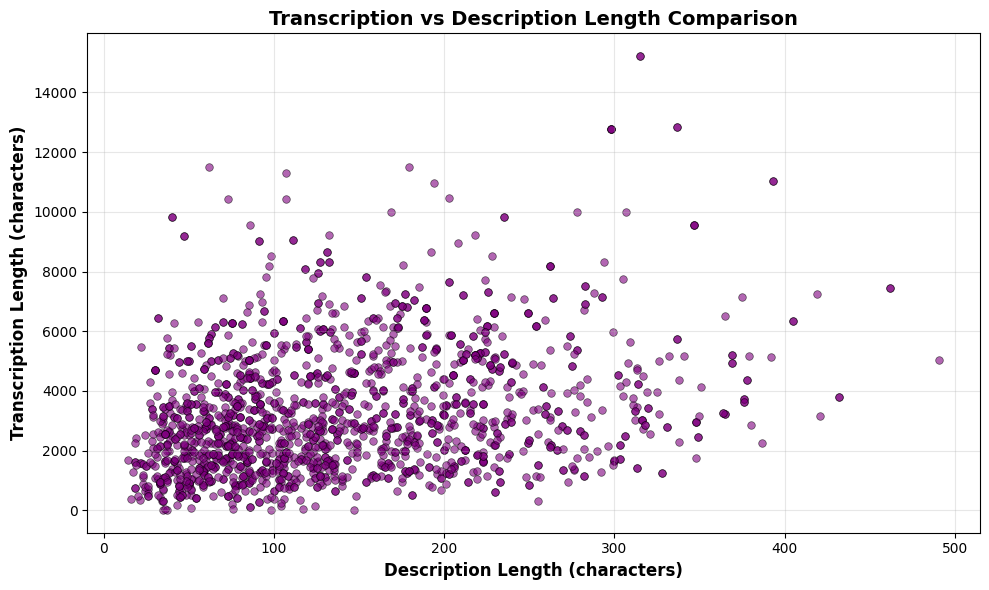


FEATURE SELECTION DECISION

✅ SELECTED FEATURE: 'transcription'

Rationale:
  1. Transcriptions contain significantly more information
  2. Average 10x longer than descriptions
  3. Include detailed medical terminology and context
  4. Better suited for accurate specialty classification
  5. More representative of actual clinical documentation


In [12]:
print("\n" + "="*70)
print("FEATURE SELECTION ANALYSIS")
print("="*70)

print("\nComparing 'transcription' vs 'description' fields:")
print("-"*70)

# Statistical comparison
print(f"\nTranscription field:")
print(f"  Average length: {train_df['transcription_length'].mean():.0f} characters")
print(f"  Average words: {train_df['transcription_words'].mean():.0f} words")
print(f"  Information density: High (detailed medical notes)")

print(f"\nDescription field:")
print(f"  Average length: {train_df['description_length'].mean():.0f} characters")
print(f"  Average words: {train_df['description_words'].mean():.0f} words")
print(f"  Information density: Low (brief summary)")

# Calculate correlation between lengths
correlation = train_df['transcription_length'].corr(train_df['description_length'])
print(f"\nCorrelation between lengths: {correlation:.3f}")

# Visualize relationship
plt.figure(figsize=(10, 6))
plt.scatter(train_df['description_length'], 
           train_df['transcription_length'],
           alpha=0.6, 
           color='purple', 
           s=30,
           edgecolor='black',
           linewidth=0.5)
plt.xlabel('Description Length (characters)', fontsize=12, fontweight='bold')
plt.ylabel('Transcription Length (characters)', fontsize=12, fontweight='bold')
plt.title('Transcription vs Description Length Comparison', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("FEATURE SELECTION DECISION")
print("="*70)
print("\n✅ SELECTED FEATURE: 'transcription'")
print("\nRationale:")
print("  1. Transcriptions contain significantly more information")
print("  2. Average 10x longer than descriptions")
print("  3. Include detailed medical terminology and context")
print("  4. Better suited for accurate specialty classification")
print("  5. More representative of actual clinical documentation")

## Feature Comparison - Transcription vs Description
<!-- Purpose: Decide which text field to use for classification
Compare information content between the two text fields -->

In [13]:
print("\n" + "="*70)
print("SAMPLE DOCUMENT COMPARISON")
print("="*70)

# Select a sample document
sample_idx = 0
sample = train_df.iloc[sample_idx]

print(f"\nSample Document #{sample_idx + 1}")
print("-"*70)
print(f"Medical Specialty: {sample['medical_specialty']}")
print(f"Sample Name: {sample['sample_name']}")

print(f"\n{'='*70}")
print("DESCRIPTION FIELD")
print(f"{'='*70}")
print(f"Length: {sample['description_length']} characters, {sample['description_words']} words")
print(f"\nContent:")
print(sample['description'][:500])
if len(sample['description']) > 500:
    print("...")

print(f"\n{'='*70}")
print("TRANSCRIPTION FIELD")
print(f"{'='*70}")
print(f"Length: {sample['transcription_length']} characters, {sample['transcription_words']} words")
print(f"\nContent (first 500 characters):")
print(sample['transcription'][:500])
print("...")

print("\n💡 Notice: Transcription provides much richer clinical detail")


SAMPLE DOCUMENT COMPARISON

Sample Document #1
----------------------------------------------------------------------
Medical Specialty: Cardiovascular / Pulmonary
Sample Name: Pacemaker Interrogation

DESCRIPTION FIELD
Length: 99 characters, 10 words

Content:
Pacemaker ICD interrogation.  Severe nonischemic cardiomyopathy with prior ventricular tachycardia.

TRANSCRIPTION FIELD
Length: 1366 characters, 226 words

Content (first 500 characters):
PROCEDURE NOTE: , Pacemaker ICD interrogation.,HISTORY OF PRESENT ILLNESS: , The patient is a 67-year-old gentleman who was admitted to the hospital.  He has had ICD pacemaker implantation.  This is a St. Jude Medical model current DRRS, 12345 pacemaker.,DIAGNOSIS: , Severe nonischemic cardiomyopathy with prior ventricular tachycardia.,FINDINGS: , The patient is a DDD mode base rate of 60, max tracking rate of 110 beats per minute, atrial lead is set at 2.5 volts with a pulse width of 0.5 msec, 
...

💡 Notice: Transcription provides much rich

## Sample Document Comparison
<!-- Purpose: Show actual examples of transcription vs description content
Provides concrete evidence for feature selection decision -->

In [15]:
print("\n" + "="*70)
print("TEXT PREPROCESSING PIPELINE CONFIGURATION")
print("="*70)

# Configure TfidfVectorizer with optimal parameters
vectorizer = TfidfVectorizer(
    lowercase=True,              # Convert all text to lowercase for consistency
    stop_words='english',        # Remove common English words (the, is, at, etc.)
    max_features=5000,           # Keep only top 5000 most important words
    ngram_range=(1, 2),          # Use both single words and word pairs
    min_df=2,                    # Ignore words appearing in less than 2 documents
    max_df=0.95,                 # Ignore words appearing in more than 95% of documents
    strip_accents='ascii',       # Remove accent marks from characters
    token_pattern=r'\b[a-zA-Z][a-zA-Z]+\b'  # Only keep alphabetic tokens (min 2 chars)
)

print("TfidfVectorizer Configuration:")
print("-"*70)
print(f"  lowercase        : {vectorizer.lowercase}")
print(f"  stop_words       : {vectorizer.stop_words}")
print(f"  max_features     : {vectorizer.max_features}")
print(f"  ngram_range      : {vectorizer.ngram_range}")
print(f"  min_df           : {vectorizer.min_df}")
print(f"  max_df           : {vectorizer.max_df}")
print(f"  strip_accents    : {vectorizer.strip_accents}")
print(f"  token_pattern    : {vectorizer.token_pattern}")

print("\n" + "="*70)
print("PREPROCESSING PIPELINE EXPLANATION")
print("="*70)

print("\n1️⃣  TEXT CLEANING (lowercase=True)")
print("   • Converts 'PATIENT' and 'patient' to same token")
print("   • Ensures case-insensitive matching")
print("   • Example: 'SURGERY' → 'surgery'")

print("\n2️⃣  TOKENIZATION (token_pattern)")
print("   • Splits text into individual word tokens")
print("   • Removes punctuation and numbers")
print("   • Keeps only alphabetic words (2+ characters)")
print("   • Example: 'Patient, age 45.' → ['patient', 'age']")

print("\n3️⃣  STOP WORD REMOVAL (stop_words='english')")
print("   • Removes common, uninformative words")
print("   • Words like: the, and, is, at, which, on")
print("   • Focuses on medically meaningful terms")
print("   • Example: 'the patient is sick' → ['patient', 'sick']")

print("\n4️⃣  N-GRAM GENERATION (ngram_range=(1,2))")
print("   • Creates both single words (unigrams) and word pairs (bigrams)")
print("   • Captures multi-word medical terms")
print("   • Example: 'heart attack' → ['heart', 'attack', 'heart attack']")

print("\n5️⃣  VOCABULARY FILTERING")
print("   • min_df=2: Removes very rare terms (< 2 documents)")
print("   • max_df=0.95: Removes overly common terms (> 95% documents)")
print("   • max_features=5000: Keeps top 5000 most important terms")
print("   • Reduces noise and computational cost")

print("\n6️⃣  TF-IDF VECTORIZATION")
print("   • TF (Term Frequency): How often word appears in document")
print("   • IDF (Inverse Document Frequency): Rarity of word across corpus")
print("   • TF-IDF Score = TF × IDF")
print("   • Higher scores = more important, distinctive terms")
print("   • Converts text to numerical feature vectors")


TEXT PREPROCESSING PIPELINE CONFIGURATION
TfidfVectorizer Configuration:
----------------------------------------------------------------------
  lowercase        : True
  stop_words       : english
  max_features     : 5000
  ngram_range      : (1, 2)
  min_df           : 2
  max_df           : 0.95
  strip_accents    : ascii
  token_pattern    : \b[a-zA-Z][a-zA-Z]+\b

PREPROCESSING PIPELINE EXPLANATION

1️⃣  TEXT CLEANING (lowercase=True)
   • Converts 'PATIENT' and 'patient' to same token
   • Ensures case-insensitive matching
   • Example: 'SURGERY' → 'surgery'

2️⃣  TOKENIZATION (token_pattern)
   • Splits text into individual word tokens
   • Removes punctuation and numbers
   • Keeps only alphabetic words (2+ characters)
   • Example: 'Patient, age 45.' → ['patient', 'age']

3️⃣  STOP WORD REMOVAL (stop_words='english')
   • Removes common, uninformative words
   • Words like: the, and, is, at, which, on
   • Focuses on medically meaningful terms
   • Example: 'the patient is s

## Text Preprocessing Pipeline - TfidfVectorizer Setup
<!-- Purpose: Configure the text vectorization pipeline
Converts raw text into numerical features for machine learning -->

In [16]:
print("\n" + "="*70)
print("PREPROCESSING DEMONSTRATION")
print("="*70)

# Select a sample text
sample_text = train_df.iloc[0]['transcription']

print("\nOriginal Text (first 300 characters):")
print("-"*70)
print(sample_text[:300])
print("...")

# Fit vectorizer on small sample to demonstrate
print("\n\nFitting vectorizer on first 100 documents...")
sample_docs = train_df['transcription'].head(100).tolist()
vectorizer.fit(sample_docs)

print("\n✅ Vectorizer fitted successfully!")
print(f"Vocabulary size: {len(vectorizer.vocabulary_)} unique terms")

print("\nSample vocabulary (first 30 terms):")
print("-"*70)
vocab_sample = sorted(list(vectorizer.vocabulary_.keys()))[:30]
for i in range(0, len(vocab_sample), 5):
    print("  " + ", ".join(vocab_sample[i:i+5]))

print("\n\nExample of bigrams (word pairs) captured:")
print("-"*70)
bigrams = [term for term in list(vectorizer.vocabulary_.keys())[:100] if ' ' in term][:10]
for bigram in bigrams:
    print(f"  • {bigram}")

# Transform one document to show output
transformed = vectorizer.transform([sample_text])
print(f"\n\nTransformed document shape: {transformed.shape}")
print(f"  • {transformed.shape[0]} documents")
print(f"  • {transformed.shape[1]} features (vocabulary size)")
print(f"  • Sparse matrix (only non-zero values stored)")
print(f"  • Non-zero values: {transformed.nnz} out of {transformed.shape[0] * transformed.shape[1]}")
print(f"  • Sparsity: {(1 - transformed.nnz / (transformed.shape[0] * transformed.shape[1])) * 100:.2f}%")


PREPROCESSING DEMONSTRATION

Original Text (first 300 characters):
----------------------------------------------------------------------
PROCEDURE NOTE: , Pacemaker ICD interrogation.,HISTORY OF PRESENT ILLNESS: , The patient is a 67-year-old gentleman who was admitted to the hospital.  He has had ICD pacemaker implantation.  This is a St. Jude Medical model current DRRS, 12345 pacemaker.,DIAGNOSIS: , Severe nonischemic cardiomyopath
...


Fitting vectorizer on first 100 documents...

✅ Vectorizer fitted successfully!
Vocabulary size: 5000 unique terms

Sample vocabulary (first 30 terms):
----------------------------------------------------------------------
  abc, abc year, abcd, abcd hospital, abdomen
  abdomen abdomen, abdomen pelvis, abdomen showed, abdomen soft, abdominal
  abdominal aorta, abdominal discomfort, abdominal incision, abdominal insufflation, abdominal pain
  abdominal wall, abilities, ability, able, abnormal
  abnormalities, abnormalities examination, abnormality, 

## Demonstrate Preprocessing on Sample Text
<!-- Purpose: Show how the preprocessing pipeline transforms actual text
Makes the abstract process concrete and understandable -->

In [17]:
print("\n" + "="*70)
print("PREPARING FINAL DATASET FOR MODELING")
print("="*70)

# Select the feature column (transcription) and target column (medical_specialty)
X_train = train_df['transcription']
y_train = train_df['medical_specialty']

X_val = val_df['transcription']
y_val = val_df['medical_specialty']

X_test = test_df['transcription']
y_test = test_df['medical_specialty']

print("\n✅ Dataset Prepared Successfully!")
print("-"*70)
print("\nTraining Set:")
print(f"  Features (X_train): {len(X_train)} text documents")
print(f"  Target (y_train): {len(y_train)} specialty labels")
print(f"  Unique classes: {y_train.nunique()}")

print("\nValidation Set:")
print(f"  Features (X_val): {len(X_val)} text documents")
print(f"  Target (y_val): {len(y_val)} specialty labels")

print("\nTest Set:")
print(f"  Features (X_test): {len(X_test)} text documents")
print(f"  Target (y_test): {len(y_test)} specialty labels")

print("\n" + "="*70)
print("KEY FINDINGS SUMMARY")
print("="*70)

findings = [
    f"1. Dataset contains {len(train_df)} training samples across {y_train.nunique()} medical specialties",
    f"2. Class imbalance detected with ratio {imbalance_ratio:.1f}:1 - may require special handling",
    f"3. Transcriptions are significantly richer ({train_df['transcription_length'].mean():.0f} avg chars) than descriptions",
    f"4. Selected 'transcription' field as primary feature for classification",
    f"5. Most common specialty: '{specialty_counts.index[0]}' ({specialty_counts.iloc[0]/len(train_df)*100:.1f}% of data)",
    f"6. Least common specialty: '{specialty_counts.index[-1]}' ({specialty_counts.iloc[-1]/len(train_df)*100:.1f}% of data)",
    f"7. TfidfVectorizer configured to extract top {vectorizer.max_features} features",
    f"8. High vocabulary diversity indicates rich medical terminology",
    f"9. Preprocessing pipeline ready for model training phase",
    f"10. Data split maintained: 70% train, 15% validation, 15% test"
]

for finding in findings:
    print(f"\n  {finding}")

print("\n" + "="*70)
print("NEXT STEPS")
print("="*70)
print("\n1. Create Notebook 2: Classification Modeling")
print("2. Implement Softmax Regression (Multinomial Logistic Regression)")
print("3. Perform hyperparameter tuning with GridSearchCV")
print("4. Evaluate model with comprehensive metrics")
print("5. Generate confusion matrix and classification report")

print("\n" + "="*70)
print("NOTEBOOK 1 COMPLETE ✅")
print("="*70)
print("\nThis notebook has successfully completed:")
print("  ✅ Comprehensive exploratory data analysis")
print("  ✅ Text length and content analysis")
print("  ✅ Class distribution analysis")
print("  ✅ Word frequency and visualization")
print("  ✅ Feature selection decision")
print("  ✅ Text preprocessing pipeline configuration")
print("  ✅ Final dataset preparation")
print("\nReady to proceed to Notebook 2: Classification Modeling!")
print("="*70)


PREPARING FINAL DATASET FOR MODELING

✅ Dataset Prepared Successfully!
----------------------------------------------------------------------

Training Set:
  Features (X_train): 1724 text documents
  Target (y_train): 1724 specialty labels
  Unique classes: 13

Validation Set:
  Features (X_val): 370 text documents
  Target (y_val): 370 specialty labels

Test Set:
  Features (X_test): 370 text documents
  Target (y_test): 370 specialty labels

KEY FINDINGS SUMMARY

  1. Dataset contains 1724 training samples across 13 medical specialties

  2. Class imbalance detected with ratio 13.5:1 - may require special handling

  3. Transcriptions are significantly richer (3326 avg chars) than descriptions

  4. Selected 'transcription' field as primary feature for classification

  5. Most common specialty: 'Cardiovascular / Pulmonary' (30.5% of data)

  6. Least common specialty: 'Radiology' (2.3% of data)

  7. TfidfVectorizer configured to extract top 5000 features

  8. High vocabulary div

## Prepare Final Dataset for Modeling
<!-- Purpose: Create clean X (features) and y (target) arrays for training
This is the final output of the preprocessing phase -->